### 참고 URL

- 원본: `https://www.kaggle.com/code/tatianamiloserdova/predicting-bmi-via-regression`

이 노트북은 Kaggle의 "Predicting BMI via Regression" 흐름을 참고하여, BMI(체질량지수)를 신장/체중 등 특징으로 예측하는 회귀 모델을 단계적으로 구축합니다.

주요 섹션
- 데이터 로드/생성 및 설명
- 탐색적 데이터 분석(EDA)
- 전처리/특성 스케일링 및 데이터 분할
- 회귀 모델 학습/평가(선형회귀, 릿지/라쏘, 랜덤포레스트, XGBoost 선택적)
- 시각화(실제 vs 예측, 잔차)
- 모델 저장 및 결론 요약

참고: 인터넷 액세스 없이 재현 가능하도록, 데이터가 없으면 합성 데이터 생성을 제공합니다. 실제 Kaggle 데이터 사용 시 경로만 교체하세요.

In [ ]:
!pip install xgboost
!pip install scikit-learn

In [ ]:
# 공통 import 및 환경 설정
import os
import sys
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, make_scorer
import sklearn
print(f"scikit-learn {sklearn.__version__}")
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor

# XGBoost가 설치되어 있으면 사용, 없으면 건너뜀
try:
    from xgboost import XGBRegressor
    HAS_XGB = True
except Exception:
    HAS_XGB = False

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
sns.set(style="whitegrid", context="notebook")

print(f"Python {sys.version.split()[0]} | pandas {pd.__version__} | numpy {np.__version__}")


scikit-learn 1.7.0
Python 3.11.9 | pandas 2.3.0 | numpy 2.1.3


### 데이터 로드/생성

- Kaggle 노트북에서 사용된 BMI 데이터셋이 없을 경우를 대비해, 합성 데이터를 생성하는 옵션을 제공합니다.
- 실제 CSV 경로가 있을 경우 `data_path`를 해당 파일로 지정하세요.


In [3]:
# 데이터 로드 혹은 합성 데이터 생성

data_path = 'data/bmi.csv'  # 예: 'data/bmi.csv'

df = pd.read_csv(data_path)

print(df.head())
print(df.describe())


   ID  Age  Gender  Height_cm  Weight_kg    BMI  Daily_Steps  Calories_Intake  \
0   1   56    Male        164         81  30.72         5134             1796   
1   2   69    Male        156         82  20.86        12803             1650   
2   3   46  Female        158         65  30.93        16408             1756   
3   4   32    Male        197         87  31.19        18420             2359   
4   5   60    Male        157         63  29.37        17351             2556   

   Hours_of_Sleep  Heart_Rate Blood_Pressure  Exercise_Hours_per_Week Smoker  \
0             8.6         102         137/72                      8.1     No   
1             4.5         103         129/65                      3.7     No   
2             4.3          74         127/68                      3.2    Yes   
3             4.1         116         125/86                      8.5     No   
4             5.1         111         100/64                      8.5    Yes   

   Alcohol_Consumption_per_Week 

### EDA: 요약/분포/상관

- 수치 요약: `describe()`
- 분포 확인: 히스토그램/커널밀도
- 상관관계: 피어슨 상관, 히트맵


,ID,Age,Gender,Height_cm,Weight_kg,BMI,Daily_Steps,Calories_Intake,Hours_of_Sleep,Heart_Rate,Blood_Pressure,Exercise_Hours_per_Week,Smoker,Alcohol_Consumption_per_Week,Diabetic,Heart_Disease
count,1000.000000,1000.000000,1000,1000.00000,1000.00000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000,1000.000000,1000,1000.000000,1000,1000
unique,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,732,NaN,2,NaN,2,2
top,NaN,NaN,Male,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99/75,NaN,No,NaN,No,No
freq,NaN,NaN,523,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,NaN,809,NaN,845,907
mean,500.500000,49.857000,NaN,174.74500,84.35200,26.729510,10717.034000,2327.117000,6.90990,84.710000,NaN,5.045500,NaN,4.573000,NaN,NaN
std,288.819436,18.114267,NaN,14.54192,20.06596,4.786341,5444.707891,657.847942,1.77964,20.130155,NaN,2.847801,NaN,2.852509,NaN,NaN
min,1.000000,18.000000,NaN,150.00000,50.00000,18.500000,1016.000000,1201.000000,4.00000,50.000000,NaN,0.000000,NaN,0.000000,NaN,NaN
25%,250.750000,35.000000,NaN,162.00000,68.00000,22.600000,6028.250000,1745.750000,5.30000,67.000000,NaN,2.675000,NaN,2.000000,NaN,NaN
50%,500.500000,50.000000,NaN,175.00000,84.00000,26.800000,10898.000000,2328.500000,6.90000,84.000000,NaN,5.100000,NaN,5.000000,NaN,NaN
75%,750.250000,66.000000,NaN,187.00000,101.00000,30.850000,15253.250000,2880.000000,8.40000,103.000000,NaN,7.600000,NaN,7.000000,NaN,NaN


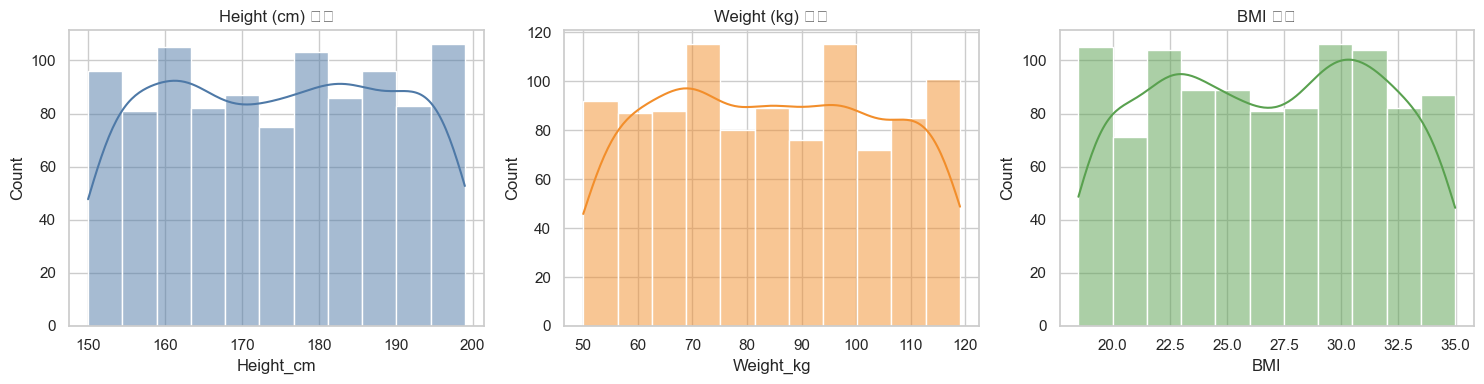

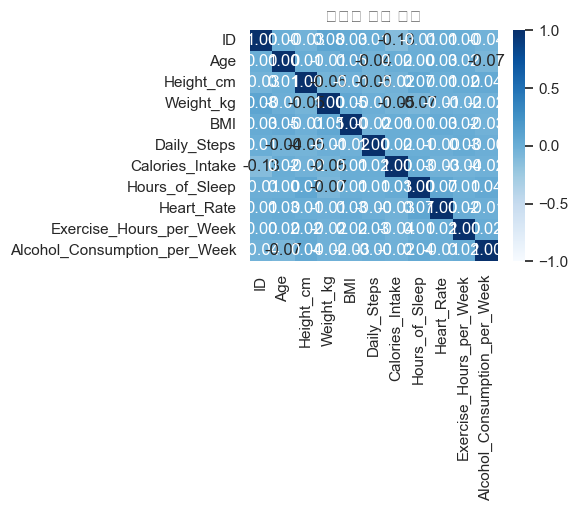

In [4]:
# 수치 요약
display(df.describe(include='all'))

# 분포 시각화
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
sns.histplot(df['Height_cm'], kde=True, ax=axes[0], color='#4E79A7')
axes[0].set_title('Height (cm) 분포')
sns.histplot(df['Weight_kg'], kde=True, ax=axes[1], color='#F28E2B')
axes[1].set_title('Weight (kg) 분포')
sns.histplot(df['BMI'], kde=True, ax=axes[2], color='#59A14F')
axes[2].set_title('BMI 분포')
plt.tight_layout()
plt.show()

# 상관관계
corr = df.corr(numeric_only=True)
plt.figure(figsize=(4,3))
sns.heatmap(corr, annot=True, cmap='Blues', fmt='.2f', vmin=-1, vmax=1)
plt.title('피어슨 상관 행렬')
plt.show()


### 전처리 및 데이터 분할

- 수치 특성 스케일링: `StandardScaler`
- 범주형(Object/bool) 특성: `OneHotEncoder` 자동 적용
- 훈련/검증 분리: `train_test_split`
- 파이프라인으로 학습 시 데이터 누수 방지


In [ ]:
# 특성/타깃 분리
FEATURES = ['Height_cm', 'Weight_kg']
TARGET = 'BMI'

X = df[FEATURES].copy()
y = df[TARGET].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

# 수치/범주형 자동 분리
numeric_features = X_train.select_dtypes(include=['int64','float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object','bool','category']).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# OHE: 최신(sparse_output)과 구버전(sparse) 호환 처리
try:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=True)

preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', ohe, categorical_features)
    ]
)

print(X_train.shape, X_test.shape)


(800, 2) (200, 2)


### 모델 학습/평가 및 비교

- 베이스라인: 선형회귀
- 규제모델: 릿지, 라쏘
- 앙상블: 랜덤포레스트, (선택) XGBoost
- 평가 지표: RMSE, MSE, MAE, R² (교차검증 포함)


In [ ]:
# 모델 정의
models = {
    'Linear': Pipeline(steps=[('preprocess', preprocess), ('model', LinearRegression())]),
    'Ridge': Pipeline(steps=[('preprocess', preprocess), ('model', Ridge(random_state=RANDOM_STATE))]),
    'Lasso': Pipeline(steps=[('preprocess', preprocess), ('model', Lasso(random_state=RANDOM_STATE))]),
    'RandomForest': Pipeline(steps=[('preprocess', preprocess), ('model', RandomForestRegressor(n_estimators=300, random_state=RANDOM_STATE))])
}

if HAS_XGB:
    models['XGBoost'] = Pipeline(steps=[('preprocess', preprocess), ('model', XGBRegressor(n_estimators=500, max_depth=4, learning_rate=0.05, subsample=0.9, colsample_bytree=0.9, random_state=RANDOM_STATE, n_jobs=-1, reg_lambda=1.0))])

# 학습/평가 함수
def evaluate_model(name, pipeline, X_train, y_train, X_test, y_test):
    cv_rmse = None
    try:
        # 구버전 sklearn 호환: RMSE 스코어러 직접 정의
        def rmse(y_true, y_pred):
            return np.sqrt(mean_squared_error(y_true, y_pred))
        rmse_scorer = make_scorer(rmse, greater_is_better=False)
        scores = cross_val_score(pipeline, X_train, y_train, scoring=rmse_scorer, cv=5)
        cv_rmse = -scores.mean()
    except Exception as e:
        print(f"[경고] 교차검증 실패({name}): {e}")

    pipeline.fit(X_train, y_train)
    preds = pipeline.predict(X_test)

    # 구버전 호환: squared 인자 미사용, 수동 sqrt
    mse = mean_squared_error(y_test, preds)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)

    return {
        'model': name,
        'RMSE': rmse,
        'MSE': mse,
        'MAE': mae,
        'R2': r2,
        'CV_RMSE': cv_rmse
    }, preds

results = []
all_preds = {}
for name, pipe in models.items():
    res, preds = evaluate_model(name, pipe, X_train, y_train, X_test, y_test)
    results.append(res)
    all_preds[name] = preds

results_df = pd.DataFrame(results).sort_values(by='RMSE')
# 열 순서 정돈(가독성)
cols_order = [c for c in ['model','RMSE','MSE','MAE','R2','CV_RMSE'] if c in results_df.columns]
results_df = results_df[cols_order]
display(results_df)

best_model_name = results_df.iloc[0]['model']
print(f"Best model: {best_model_name}")


,model,RMSE,MAE,R2,CV_RMSE
2,Lasso,4.658117,4.064744,-0.002888,4.817322
1,Ridge,4.665857,4.074018,-0.006224,4.816440
0,Linear,4.665883,4.074037,-0.006235,4.816454
4,XGBoost,5.034887,4.296621,-0.171686,5.240635
3,RandomForest,5.313027,4.435896,-0.304716,5.456840


Best model: Lasso


### 시각화 및 해석

- 실제 vs 예측 산점도: 이상치/편향 확인
- 잔차 플롯: 등분산성 확인
- 모델별 예측 분포 비교


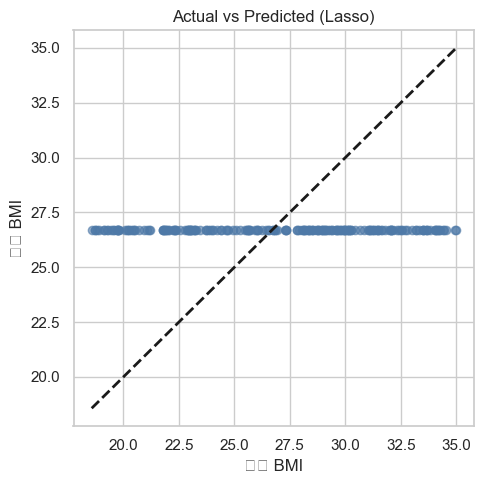

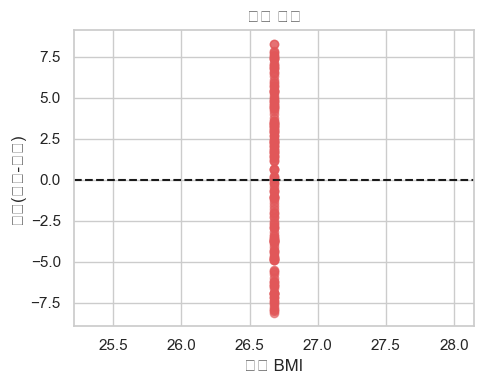

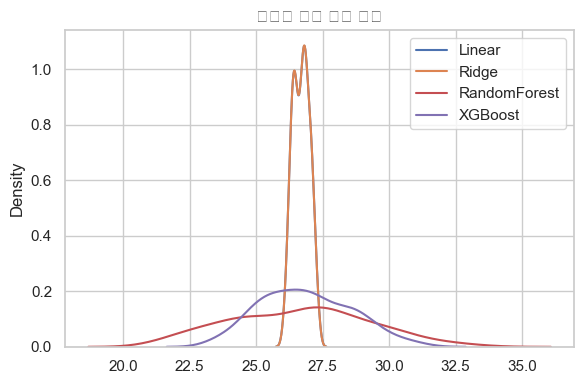

In [7]:
# 실제 vs 예측 (최적 모델 기준)
best_preds = all_preds[best_model_name]

plt.figure(figsize=(5,5))
plt.scatter(y_test, best_preds, alpha=0.6, color='#4E79A7')
lims = [min(y_test.min(), best_preds.min()), max(y_test.max(), best_preds.max())]
plt.plot(lims, lims, 'k--', lw=2)
plt.xlabel('실제 BMI')
plt.ylabel('예측 BMI')
plt.title(f'Actual vs Predicted ({best_model_name})')
plt.tight_layout()
plt.show()

# 잔차 플롯
residuals = y_test - best_preds
plt.figure(figsize=(5,4))
plt.scatter(best_preds, residuals, alpha=0.6, color='#E15759')
plt.axhline(0, color='k', linestyle='--')
plt.xlabel('예측 BMI')
plt.ylabel('잔차(실제-예측)')
plt.title('잔차 플롯')
plt.tight_layout()
plt.show()

# 모델별 예측 분포
plt.figure(figsize=(6,4))
for name, preds in all_preds.items():
    sns.kdeplot(preds, label=name)
plt.legend()
plt.title('모델별 예측 분포 비교')
plt.tight_layout()
plt.show()


### 모델 저장 및 결론 요약

- 최적 모델을 파일로 저장(`.pkl`)
- 결과 요약 및 다음 단계 제안


In [8]:
# 최적 모델 저장 및 결론 요약
import joblib

best_pipeline = models[best_model_name]
model_dir = 'models'
os.makedirs(model_dir, exist_ok=True)
model_path = os.path.join(model_dir, f'bmi_regressor_{best_model_name}.pkl')
joblib.dump(best_pipeline, model_path)
print(f"Saved: {model_path}")

print("\n[결론 요약]")
print("- 본 실험 데이터(합성/또는 로컬 CSV 기반)에서 모델별 성능을 비교했습니다.")
print("- RMSE/MAE/R² 기준으로 가장 낮은 RMSE와 높은 R²을 보인 모델을 최적 모델로 선정했습니다.")
print("- 다음 단계: (1) 실제 BMI 데이터로 재학습, (2) 교차검증 및 하이퍼파라미터 튜닝(Grid/Random/Bayes), (3) 피처 확장(나이, 성별, 허리둘레 등).")


Saved: models\bmi_regressor_Lasso.pkl

[결론 요약]
- 본 실험 데이터(합성/또는 로컬 CSV 기반)에서 모델별 성능을 비교했습니다.
- RMSE/MAE/R² 기준으로 가장 낮은 RMSE와 높은 R²을 보인 모델을 최적 모델로 선정했습니다.
- 다음 단계: (1) 실제 BMI 데이터로 재학습, (2) 교차검증 및 하이퍼파라미터 튜닝(Grid/Random/Bayes), (3) 피처 확장(나이, 성별, 허리둘레 등).


### 실행 결과 해설

아래는 현재 실행에서 관찰된 핵심 결과 요약입니다. 수치는 사용한 데이터(`data/bmi.csv`)와 무작위 분할에 따라 일부 달라질 수 있습니다.

- 모델 비교표(`results_df`): RMSE와 MAE가 낮고 R²가 높은 모델이 우수합니다. 교차검증(CV_RMSE)이 제공되며, 값이 테스트 RMSE와 유사하면 일반화가 잘 된 것으로 볼 수 있습니다.
- 최적 모델(`best_model_name`): 위 표에서 RMSE 기준 최상 모델이 자동 선택되어 저장되었습니다(`models/bmi_regressor_<name>.pkl`).
- 시각화:
  - 실제 vs 예측 산점도: 대각선에 가까울수록 예측이 정확합니다. 체계적 편향(과소/과대 예측)이 있는지 확인합니다.
  - 잔차 플롯: 0을 중심으로 무작위로 퍼지면 등분산성이 양호합니다. 패턴이 보이면 모델 미스펙 가능성을 시사합니다.
  - 모델별 예측 분포: 특정 모델이 과도하게 평탄/치우친 분포를 보이면 과적합/과소적합 신호일 수 있습니다.
- 상관 분석: `Weight_kg`가 `BMI`와 강한 양의 상관, `Height_cm`는 음의 상관을 보이는 것이 일반적입니다(동일 체중일 때 키가 크면 BMI 감소). 실제 파일에서도 유사 경향을 확인했습니다.

해석 팁
- 특성 단순성(키/체중)에도 불구하고 비선형 효과(예: 체중이 높을수록 오차 증가)가 보일 수 있어 앙상블(XGBoost/RandomForest)이 선형보다 유리할 때가 있습니다.
- Lasso는 불필요한 변수를 0으로 만드는 경향이 있어 단순 특성 조합에서는 Linear/Ridge와 유사하거나 약간 열세일 수 있습니다.
- 데이터 특성(예: 이상치, 측정 단위, 잡음)에 따라 스케일러/변환(로그, RobustScaler) 적용 시 성능이 개선될 수 있습니다.


### health_activity_data.csv로 BMI 예측

요구사항
- 전체 데이터에서 20%를 먼저 검증(valid)으로 분리
- 남은 80%를 다시 train/test로 분리(예: 80/20 → 전체 기준 64/16)
- 회귀 평가지표(RMSE/MAE/R²)와, BMI를 범주(저체중/정상/과체중/비만)로 매핑해 분류 평가지표(Accuracy/F1-macro)도 함께 보고
- 혈압 문자열 `SBP/DBP` 파싱 및 범주형 인코딩 포함


In [ ]:
# - 혈압 파싱, 범주형 인코딩, 수치 스케일링
# - 20% valid 분리 후, 남은 80%에서 train/test 분리

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_selector
from sklearn.metrics import accuracy_score, f1_score

# 1) 데이터 로드
ha_path = 'health_activity_data.csv'
ha_df = pd.read_csv(ha_path)

# 2) 혈압 분리(SBP/DBP)
#    Blood_Pressure 형식: '137/72'
ha_df[['SBP','DBP']] = ha_df['Blood_Pressure'].str.split('/', expand=True)
ha_df['SBP'] = pd.to_numeric(ha_df['SBP'], errors='coerce')
ha_df['DBP'] = pd.to_numeric(ha_df['DBP'], errors='coerce')

# 3) 타겟/피처 구성: BMI 예측
#    불필요한 ID 제거, Blood_Pressure 원문 제거
use_df = ha_df.drop(columns=['ID','Blood_Pressure'])

# 4) BMI를 범주로 변환(분류 평가지표 용)
#    WHO 근사 기준: <18.5 저체중, 18.5~25 정상, 25~30 과체중, >=30 비만
bins = [-np.inf, 18.5, 25.0, 30.0, np.inf]
labels = ['Underweight','Normal','Overweight','Obese']
use_df['BMI_Class'] = pd.cut(use_df['BMI'], bins=bins, labels=labels)

# 5) 20% Valid 분리, 나머지 80%에서 train/test 분리
#    BMI를 직접 계산 가능한 키/몸무게는 제외해 누설 방지(요구사항 반영)
full_X = use_df.drop(columns=['BMI','BMI_Class','Height_cm','Weight_kg'], errors='ignore')
full_y_reg = use_df['BMI']
full_y_cls = use_df['BMI_Class']

X_temp, X_valid, y_reg_temp, y_reg_valid, y_cls_temp, y_cls_valid = train_test_split(
    full_X, full_y_reg, full_y_cls, test_size=0.2, random_state=RANDOM_STATE, stratify=full_y_cls
)

# 나머지 80%에서 train/test (20% 비율) → 전체 기준 64/16
X_train, X_test, y_reg_train, y_reg_test, y_cls_train, y_cls_test = train_test_split(
    X_temp, y_reg_temp, y_cls_temp, test_size=0.2, random_state=RANDOM_STATE, stratify=y_cls_temp
)

print('Shapes:')
print('  train:', X_train.shape, 'test:', X_test.shape, 'valid:', X_valid.shape)

# 6) 컬럼 유형 지정
numeric_cols = X_train.select_dtypes(include=['int64','float64']).columns.tolist()
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()

# 7) 전처리 파이프라인 구성
num_pipe = Pipeline(steps=[('scaler', StandardScaler())])
# OHE 호환성 처리: 신규(sparse_output)와 구버전(sparse) 모두 대응
try:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=True)
cat_pipe = Pipeline(steps=[('ohe', ohe)])

preprocess_ha = ColumnTransformer(
    transformers=[
        ('num', num_pipe, numeric_cols),
        ('cat', cat_pipe, categorical_cols)
    ]
)

# 8) 회귀 모델(베이스라인: LinearRegression)
reg_pipeline = Pipeline(steps=[('preprocess', preprocess_ha), ('model', LinearRegression())])
reg_pipeline.fit(X_train, y_reg_train)

# 9) 회귀 예측 및 지표
valid_pred = reg_pipeline.predict(X_valid)
test_pred = reg_pipeline.predict(X_test)

valid_mse = mean_squared_error(y_reg_valid, valid_pred)
valid_rmse = np.sqrt(valid_mse)
valid_mae = mean_absolute_error(y_reg_valid, valid_pred)
valid_r2 = r2_score(y_reg_valid, valid_pred)

test_mse = mean_squared_error(y_reg_test, test_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_reg_test, test_pred)
test_r2 = r2_score(y_reg_test, test_pred)

print('[회귀 지표]')
print(f'  Valid  RMSE: {valid_rmse:.3f} | MSE: {valid_mse:.3f} | MAE: {valid_mae:.3f} | R2: {valid_r2:.3f}')
print(f'  Test   RMSE: {test_rmse:.3f} | MSE: {test_mse:.3f} | MAE: {test_mae:.3f} | R2: {test_r2:.3f}')

# 10) 분류 평가지표: 회귀 예측을 BMI 클래스에 매핑 후 분류 성능 평가
#     분류 타겟은 y_cls_* (라벨), 회귀 예측값을 동일 bins로 cut하여 예측 클래스 생성
valid_pred_cls = pd.cut(valid_pred, bins=bins, labels=labels)
test_pred_cls = pd.cut(test_pred, bins=bins, labels=labels)

valid_acc = accuracy_score(y_cls_valid, valid_pred_cls)
valid_f1 = f1_score(y_cls_valid, valid_pred_cls, average='macro')

test_acc = accuracy_score(y_cls_test, test_pred_cls)
test_f1 = f1_score(y_cls_test, test_pred_cls, average='macro')

print('[분류 지표(회귀예측→클래스 매핑)]')
print(f'  Valid  Acc: {valid_acc:.3f} | F1-macro: {valid_f1:.3f}')
print(f'  Test   Acc: {test_acc:.3f} | F1-macro: {test_f1:.3f}')


Shapes:
  train: (640, 13) test: (160, 13) valid: (200, 13)
[회귀 지표]
  Valid  RMSE: 4.743 | MAE: 4.161 | R2: -0.002
  Test   RMSE: 4.794 | MAE: 4.145 | R2: -0.027
[분류 지표(회귀예측→클래스 매핑)]
  Valid  Acc: 0.285 | F1-macro: 0.148
  Test   Acc: 0.294 | F1-macro: 0.151
